# Single Sample Method Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 14.08.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../../nichecompass-reproducibility/utils")

In [5]:
import os
import warnings
from datetime import datetime

import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import plottable
import scanpy as sc
import scib_metrics
import seaborn as sns
from matplotlib import gridspec
from matplotlib.colors import LinearSegmentedColormap
from plottable import ColumnDefinition, Table
from plottable.cmap import normed_cmap
from plottable.formatters import tickcross
from plottable.plots import bar

#from nichecompass.benchmarking import compute_benchmarking_metrics
from nichecompass.utils import (add_gps_from_gp_dict_to_adata,
                                extract_gp_dict_from_mebocost_es_interactions,
                                extract_gp_dict_from_nichenet_lrt_interactions,
                                extract_gp_dict_from_omnipath_lr_interactions,
                                filter_and_combine_gp_dict_gps)

import color_utils

### 1.2 Define Parameters

In [6]:
spatial_key = "spatial"

### 1.3 Run Notebook Setup

In [7]:
sc.set_figure_params(figsize=(6, 6))

In [8]:
# Ignore future warnings and user warnings
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)
warnings.simplefilter(action="ignore", category=DeprecationWarning)

In [9]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [10]:
data_folder_path = "../../datasets/srt_data/gold"
artifact_folder_path = f"../../artifacts"
gp_data_folder_path = "../../datasets/gp_data" # gene program data
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

## 2. Method Benchmarking

- Run all model notebooks in the ```notebooks/single_sample_method_benchmarking``` directory before continuing.

### 2.1 Latent Space Comparison

#### 2.1.2 Visualize Results

##### 2.1.2.1 seqFISH Mouse Organogenesis

FileNotFoundError: [Errno 2] Unable to open file (unable to open file: name = '../../datasets/srt_data/goldseqfish_mouse_organogenesis_embryo2_scvi.h5ad', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

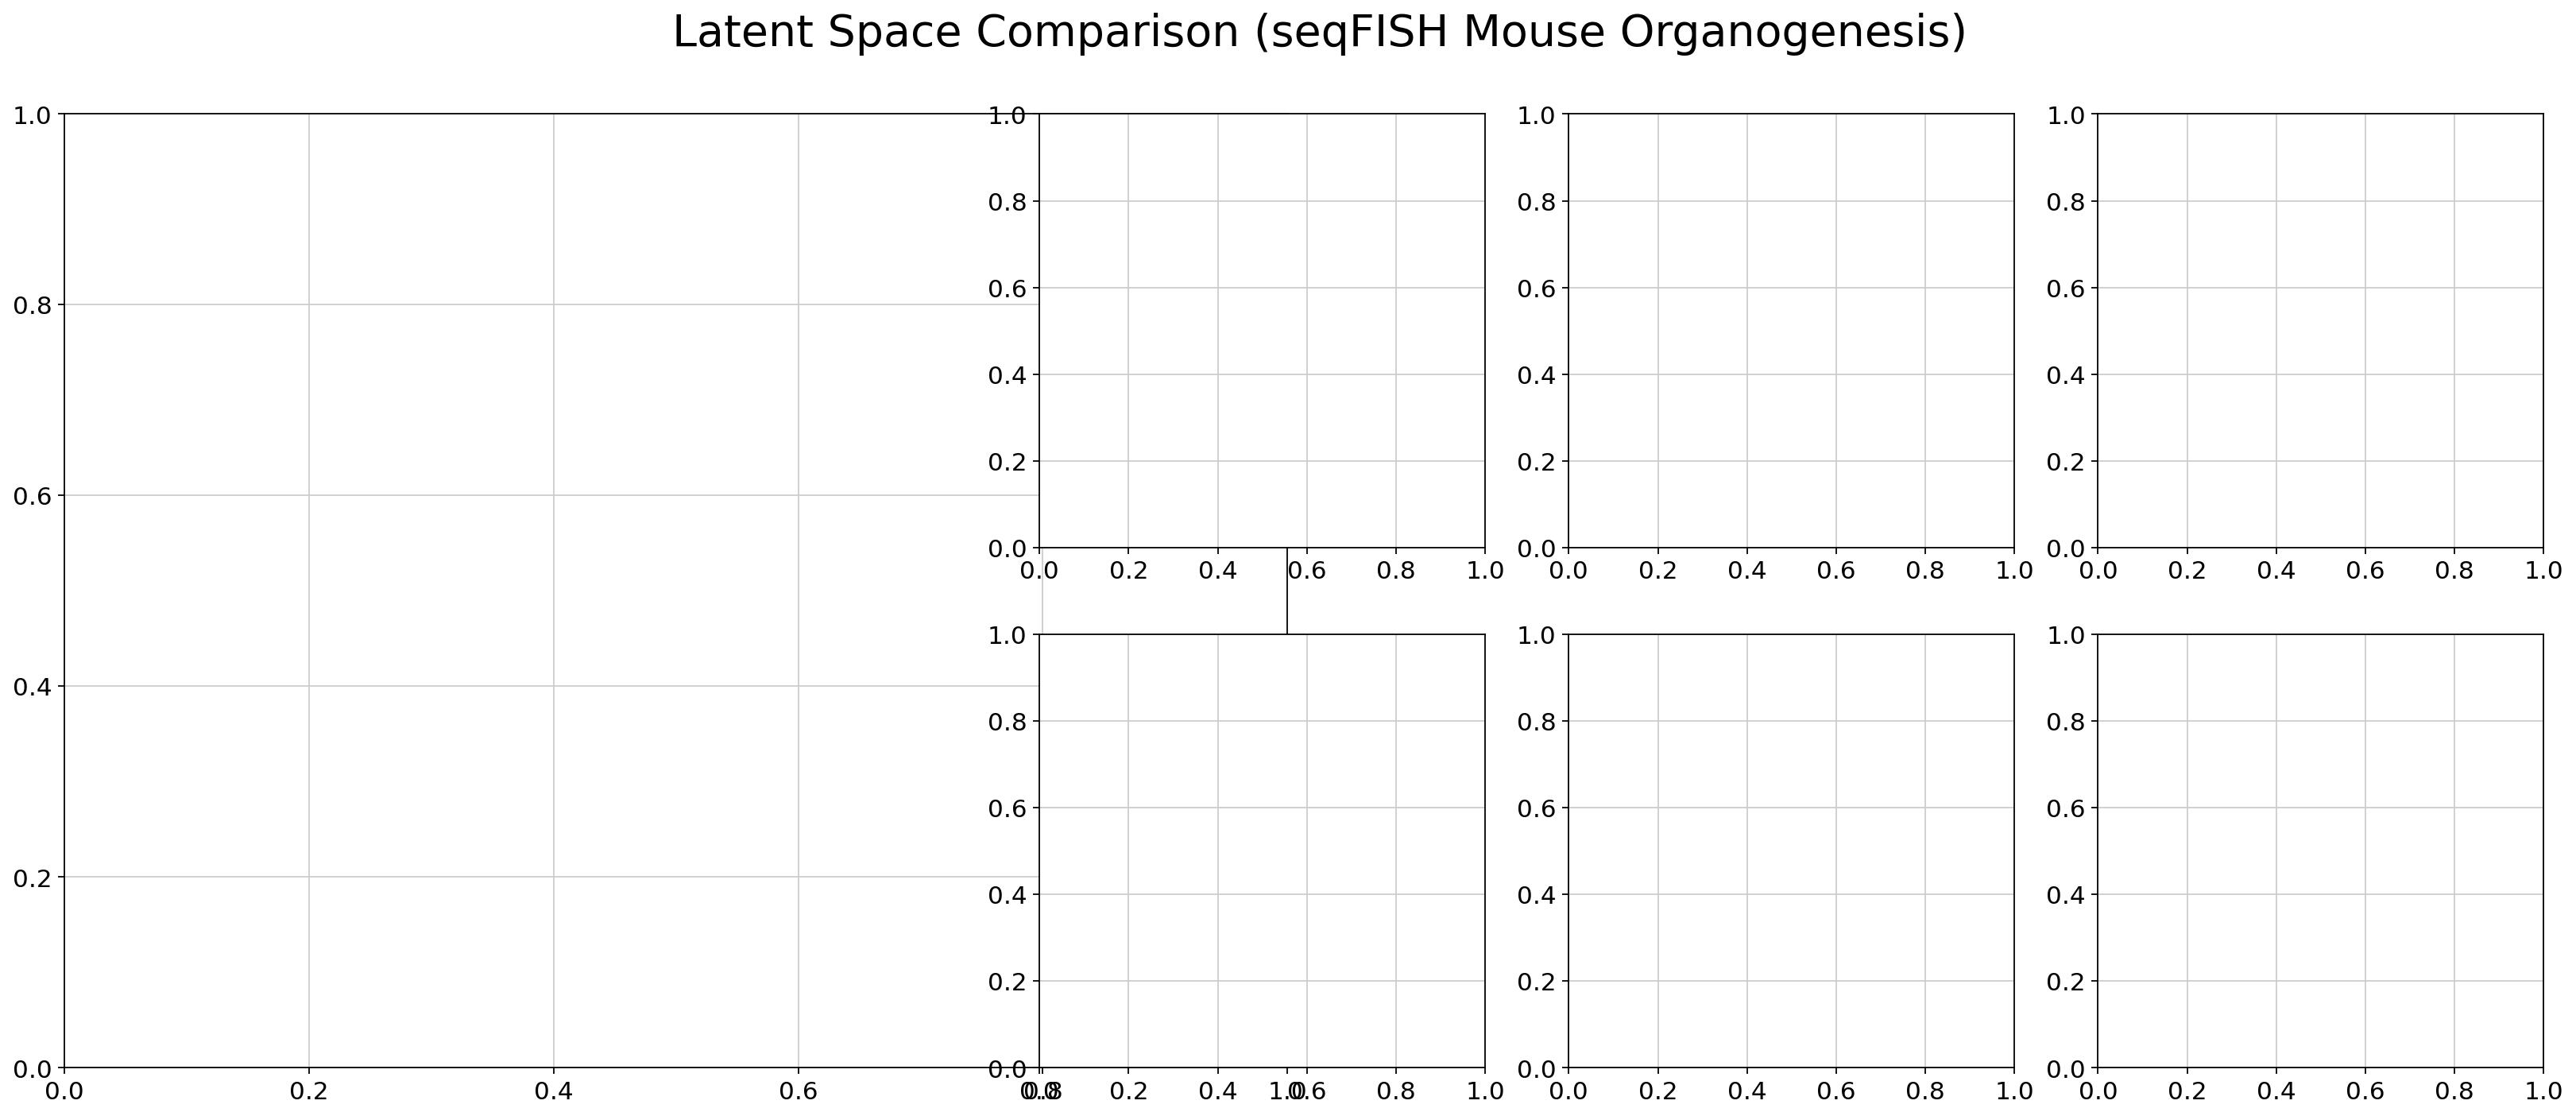

In [12]:
compute_latent_space_comparison(
    dataset="seqfish_mouse_organogenesis_embryo2",
    cell_type_colors=color_utils.seqfish_mouse_organogenesis_cell_type_colors,
    cell_type_groups=None,
    n_neighbors=12,
    run_number=5,
    spot_size=0.03)

In [ ]:
compute_latent_space_comparison(dataset="seqfish_mouse_organogenesis_embryo2",
                                cell_type_colors=seqfish_mouse_organogenesis_embryo2_cell_type_colors,
                                cell_type_groups="Mixed mesenchymal mesoderm", # "Gut tube",
                                n_neighbors=12,
                                run_number=5,
                                spot_size=0.03)

##### 2.1.2.2 MERFISH Mouse Liver

In [ ]:
# DeepLinc did not work on this dataset
compute_latent_space_comparison(dataset="vizgen_merfish_mouse_liver",
                                cell_type_colors=vizgen_merfish_mouse_liver_cell_type_colors,
                                n_neighbors=12,
                                run_number=5,
                                included_models=["NicheCompass",
                                                 "expiMap",
                                                 "scVI"],
                                spot_size=20.0)

In [ ]:
# DeepLinc did not work on this dataset
compute_latent_space_comparison(dataset="vizgen_merfish_mouse_liver_sample",
                                cell_type_colors=vizgen_merfish_mouse_liver_cell_type_colors,
                                n_neighbors=12,
                                run_number=5,
                                included_models=["NicheCompass",
                                                 "GraphST",
                                                 "SageNet",
                                                 "expiMap",
                                                 "scVI"],
                                spot_size=20.0)

##### 2.1.2.3 STARmap PLUS Mouse CNS

In [ ]:
compute_latent_space_comparison(dataset="starmap_plus_mouse_cns",
                                cell_type_colors=starmap_pluse_mouse_cns_cell_type_colors,
                                n_neighbors=12,
                                run_number=5,
                                included_models=["NicheCompass",
                                                 "expiMap",
                                                 "scVI"],
                                spot_size=0.2)

In [ ]:
compute_latent_space_comparison(dataset="starmap_plus_mouse_cns_sample",
                                cell_type_colors=starmap_pluse_mouse_cns_cell_type_colors,
                                n_neighbors=12,
                                run_number=5,
                                spot_size=0.2)

##### 2.1.2.4 NanoString CosMx Human NSCLC

In [ ]:
compute_latent_space_comparison(dataset="nanostring_cosmx_human_nsclc",
                                cell_type_colors=nanostring_cosmx_human_nsclc_cell_type_colors,
                                n_neighbors=12,
                                run_number=5,
                                included_models=["NicheCompass",
                                                 "expiMap",
                                                 "scVI"],
                                spot_size=100.0)

In [ ]:
compute_latent_space_comparison(dataset="nanostring_cosmx_human_nsclc_sample",
                                cell_type_colors=nanostring_cosmx_human_nsclc_cell_type_colors,
                                n_neighbors=12,
                                run_number=5,
                                spot_size=100.0)

### 2.2 Benchmarking Metrics

#### 2.2.1 Define Functions

In [ ]:
def compute_combined_benchmarking_metrics(model_adata,
                                          model_name,
                                          cell_type_key="cell_type",
                                          run_number_list=list(np.arange(1, 11)),
                                          n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                          ger_genes=None):
    benchmarking_dict_list = []
    for run_number, n_neighbors in zip(run_number_list, n_neighbors_list):
        
        # Compute NicheCompass metrics
        benchmarking_dict = compute_benchmarking_metrics(adata=model_adata,
                                                         latent_key=f"{model_name}_latent_run{run_number}",
                                                         cell_type_key=cell_type_key,
                                                         spatial_key=spatial_key,
                                                         spatial_knng_key=f"spatial_{n_neighbors}nng",
                                                         latent_knng_key=f"{model_name}_latent_{n_neighbors}nng_run{run_number}",
                                                         ger_genes=ger_genes)
        benchmarking_dict["model_name"] = model_name
        benchmarking_dict["run"] = run_number
        benchmarking_dict_list.append(benchmarking_dict)
    return benchmarking_dict_list

In [ ]:
def compute_combined_benchmarking_metrics_for_all_models(
        dataset,
        cell_type_key="cell_type",
        run_number_list=list(np.arange(1, 11)),
        n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
        use_only_gp_mask_target_genes_for_gene_expr_regr=True,
        included_models=["nichecompass",
                         "deeplinc",
                         "graphst",
                         "sagenet",
                         "expimap",
                         "scvi",
                         "pca"]):
    # Configure dataset artifact folder path
    dataset_artifact_folder_path = f"../../artifacts/{dataset}/method_benchmarking/comparison/{current_timestamp}"
    os.makedirs(dataset_artifact_folder_path, exist_ok=True)
    
    if use_only_gp_mask_target_genes_for_gene_expr_regr:
        # Identify genes that are available in gp mask as target genes
        print("Retrieving gp mask target genes...")
        adata = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
        
        nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
            keep_target_genes_ratio=0.01,
            max_n_target_genes_per_gp=20000,
            load_from_disk=False,
            save_to_disk=False,
            file_path=nichenet_ligand_target_mx_file_path)

        omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
            min_curation_effort=0,
            load_from_disk=False,
            save_to_disk=False,
            file_path=omnipath_lr_interactions_file_path)

        mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
            dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
            species="mouse",
            genes_uppercase=True)

        # Combine gene programs into one dictionary
        combined_gp_dict = dict(nichenet_gp_dict)
        combined_gp_dict.update(omnipath_gp_dict)
        combined_gp_dict.update(mebocost_gp_dict)

        # Filter and combine gene programs
        combined_new_gp_dict = filter_and_combine_gp_dict_gps(
            gp_dict=combined_gp_dict,
            gp_filter_mode="subset", #None,
            combine_overlap_gps=True, #True,
            overlap_thresh_source_genes=0.9,
            overlap_thresh_target_genes=0.9,
            overlap_thresh_genes=0.9,
            verbose=True)

        # Add the gene program dictionary as binary masks to the adata for model training
        add_gps_from_gp_dict_to_adata(
            gp_dict=combined_new_gp_dict,
            adata=adata,
            genes_uppercase=True,
            gp_targets_mask_key="nichecompass_gp_targets",
            gp_sources_mask_key="nichecompass_gp_sources",
            gp_names_key="nichecompass_gp_names",
            min_genes_per_gp=1,
            min_source_genes_per_gp=0,
            min_target_genes_per_gp=0,
            max_genes_per_gp=None,
            max_source_genes_per_gp=None,
            max_target_genes_per_gp=None)

        ger_genes = adata.var_names[adata.uns["nichecompass_target_genes_idx"]].tolist()
        del(adata)
    else:
        ger_genes = None
    
    # PCA
    if "pca" in included_models:
        print("Computing metrics for PCA...")
        adata_pca = sc.read_h5ad(data_folder_path + f"{dataset}_pca.h5ad")
        benchmarking_dict_list_pca = compute_combined_benchmarking_metrics(
            model_adata=adata_pca,
            model_name="pca",
            run_number_list=run_number_list,
            n_neighbors_list=n_neighbors_list,
            cell_type_key=cell_type_key,
            ger_genes=ger_genes)   
    
        benchmarking_dict_list = benchmarking_dict_list_pca
        with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
            pickle.dump(benchmarking_dict_list, f)
        del(adata_pca)
        print("")
    
    # scVI
    if "scvi" in included_models:
        print("Computing metrics for scVI...")
        adata_scvi = sc.read_h5ad(data_folder_path + f"{dataset}_scvi.h5ad")
        benchmarking_dict_list_scvi = compute_combined_benchmarking_metrics(
            model_adata=adata_scvi,
            model_name="scvi",
            run_number_list=run_number_list,
            n_neighbors_list=n_neighbors_list,
            cell_type_key=cell_type_key,
            ger_genes=ger_genes)  
        benchmarking_dict_list += benchmarking_dict_list_scvi
        with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
            pickle.dump(benchmarking_dict_list, f)
        del(adata_scvi)
        print("")

    # expiMap
    if "expimap" in included_models:
        print("Computing metrics for expiMap...")
        adata_expimap = sc.read_h5ad(data_folder_path + f"{dataset}_expimap.h5ad")
        benchmarking_dict_list_expimap = compute_combined_benchmarking_metrics(
            model_adata=adata_expimap,
            model_name="expimap",
            run_number_list=run_number_list,
            n_neighbors_list=n_neighbors_list,
            cell_type_key=cell_type_key,
            ger_genes=ger_genes)  
        benchmarking_dict_list += benchmarking_dict_list_expimap
        with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
            pickle.dump(benchmarking_dict_list, f)
        del(adata_expimap)
        print("")
    
    # SageNet
    if "sagenet" in included_models:
        print("Computing metrics for SageNet...")
        adata_sagenet = sc.read_h5ad(data_folder_path + f"{dataset}_sagenet.h5ad")
        benchmarking_dict_list_sagenet = compute_combined_benchmarking_metrics(
            model_adata=adata_sagenet,
            model_name="sagenet",
            run_number_list=run_number_list,
            n_neighbors_list=n_neighbors_list,
            cell_type_key=cell_type_key,
            ger_genes=ger_genes) 
        benchmarking_dict_list += benchmarking_dict_list_sagenet
        with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
            pickle.dump(benchmarking_dict_list, f)
        del(adata_sagenet)
        print("")
    
    # DeepLinc
    if "deeplinc" in included_models:
        print("Computing metrics for DeepLinc...")
        adata_deeplinc = sc.read_h5ad(data_folder_path + f"{dataset}_deeplinc.h5ad")
        benchmarking_dict_list_deeplinc = compute_combined_benchmarking_metrics(
            model_adata=adata_deeplinc,
            model_name="deeplinc",
            run_number_list=run_number_list,
            n_neighbors_list=n_neighbors_list,
            cell_type_key=cell_type_key,
            ger_genes=ger_genes)
        benchmarking_dict_list += benchmarking_dict_list_deeplinc
        with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
            pickle.dump(benchmarking_dict_list, f)
        del(adata_deeplinc)
        print("")
    
    # GraphST
    if "graphst" in included_models:
        print("Computing metrics for GraphST...")
        adata_graphst = sc.read_h5ad(data_folder_path + f"{dataset}_graphst.h5ad")
        benchmarking_dict_list_graphst = compute_combined_benchmarking_metrics(
            model_adata=adata_graphst,
            model_name="graphst",
            run_number_list=run_number_list,
            n_neighbors_list=n_neighbors_list,
            cell_type_key=cell_type_key,
            ger_genes=ger_genes)
        benchmarking_dict_list += benchmarking_dict_list_graphst
        with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
            pickle.dump(benchmarking_dict_list, f)
        del(adata_graphst)
        print("")

    # NicheCompass
    if "nichecompass" in included_models:
        print("Computing metrics for NicheCompass...")
        adata_nichecompass = sc.read_h5ad(data_folder_path + f"{dataset}_nichecompass.h5ad")
        benchmarking_dict_list_nichecompass = compute_combined_benchmarking_metrics(
            model_adata=adata_nichecompass,
            model_name="nichecompass",
            run_number_list=run_number_list,
            n_neighbors_list=n_neighbors_list,
            cell_type_key=cell_type_key,
            ger_genes=ger_genes)
        benchmarking_dict_list += benchmarking_dict_list_nichecompass
        with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
            pickle.dump(benchmarking_dict_list, f)
        del(adata_nichecompass)
        print("")

In [ ]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

def plot_benchmarking_results(df,
                              show=True,
                              save_dir=None,
                              save_name="benchmarking_results.svg"):
    datasets = df["dataset"].unique().tolist()
    df = df.pivot(index=["model_name", "spatially_aware"], columns=["dataset", "score_type"], values="score")
    df.reset_index(inplace=True)
    df.columns = ['_'.join(col).strip("_") for col in df.columns.values]
    if len(datasets) > 1:
        for i, dataset in enumerate(datasets):
            df[f"Total ({i})"] = df[[col for col in list(df.columns) if dataset in col]].mean(axis=1)
        df["Total (All)"] = df[list(set(list(df.columns)) - set(["model_name", "spatially_aware"]))].mean(axis=1)
        df.sort_values(by=["Total (All)"], inplace=True, ascending=False)
    else:
        df["Total"] = df[list(set(list(df.columns)) - set(["model_name"]))].mean(axis=1)
        df.sort_values(by=["Total"], inplace=True, ascending=False)
    df.rename(columns={"model_name": "Model"}, inplace=True)
    
    cmap_fn = lambda col_data: normed_cmap(col_data, cmap=matplotlib.cm.PRGn, num_stds=2.5)

    column_definitions = [
        ColumnDefinition(name="Model",
                         title="Model",
                         width=1.5,
                         textprops={"ha": "left", "weight": "bold"}),
        ColumnDefinition(name="spatially_aware",
                         title="Spatially \n Aware",
                         width=1.,
                         formatter=tickcross)]

    metric_cols = ["cas", "clisis", "gcs", "mlami"]
    aggregate_cols = [col for col in list(df.columns) if "Total" in col]

    for i, dataset in enumerate(datasets):
        if len(datasets) > 1:
            dataset_number_string = f"({i})"
        else:
            dataset_number_string = ""
        # Circles for the metric columns
        column_definitions += [
            ColumnDefinition(
                name=f"{dataset}_{col}",
                title=col.upper(),
                width=1,
                textprops={
                    "ha": "center",
                    "bbox": {"boxstyle": "circle", "pad": 0.25}},
                cmap=cmap_fn(df[f"{dataset}_{col}"]),
                group=f"Metrics \n {dataset.replace('_', ' ').title()} {dataset_number_string}",
                border="left" if j == 0 else None,
                formatter="{:.2f}")
            for j, col in enumerate(metric_cols)]

        # Bars for the aggregate columns
        column_definitions += [
            ColumnDefinition(
                name=col,
                title=col,
                width=1,
                plot_fn=bar,
                plot_kw={
                    "cmap": truncate_colormap(matplotlib.cm.YlOrRd, 0, 0.8),
                    "plot_bg_bar": False,
                    "annotate": True,
                    "height": 0.9,
                    "formatter": "{:.2f}",
                },
                group="Aggregate Scores",
                border="left" if j == 0 else None)
            for j, col in enumerate(aggregate_cols)]
        
    # Allow to manipulate text post-hoc (in illustrator)
    with matplotlib.rc_context({"svg.fonttype": "none"}):
        fig, ax = plt.subplots(figsize=(len(df.columns) * 1., 3 + 0.3 * len(df.columns)))
        tab = Table(
            df,
            cell_kw={
                "linewidth": 0,
                "edgecolor": "k"},
            column_definitions=column_definitions,
            ax=ax,
            row_dividers=True,
            footer_divider=True,
            textprops={"fontsize": 10, "ha": "center"},
            row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
            col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
            column_border_kw={"linewidth": 1, "linestyle": "-"},
            index_col="Model",
        ).autoset_fontcolors(colnames=df.columns)
    if show:
        plt.show()
    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)        
        fig.savefig(os.path.join(save_dir, save_name), facecolor=ax.get_facecolor(), dpi=300)
    return tab

#### 2.2.2 Compute Benchmarking Metrics

In [ ]:
compute_combined_benchmarking_metrics_for_all_models(
    dataset="seqfish_mouse_organogenesis_embryo2")

In [ ]:
compute_combined_benchmarking_metrics_for_all_models(
    dataset="vizgen_merfish_mouse_liver")

In [ ]:
compute_combined_benchmarking_metrics_for_all_models(
    dataset="vizgen_merfish_mouse_liver_sample")

In [ ]:
compute_combined_benchmarking_metrics_for_all_models(
    dataset="starmap_plus_mouse_cns")

In [ ]:
compute_combined_benchmarking_metrics_for_all_models(
    dataset="starmap_plus_mouse_cns_sample")

In [ ]:
compute_combined_benchmarking_metrics_for_all_models(
    dataset="nanostring_cosmx_human_nsclc")

In [ ]:
compute_combined_benchmarking_metrics_for_all_models(
    dataset="nanostring_cosmx_human_nsclc_sample")

#### 3.2.3 Visualize Results

In [ ]:
df = pd.DataFrame()
datasets = ["seqfish_mouse_organogenesis_embryo2",
            "starmap_plus_mouse_cns_sample",
            "nanostring_cosmx_human_nsclc_sample"]
timestamps = ["07032023_193322",
              "07032023_071219",
              "07032023_080409"]

for dataset, timestamp in zip(datasets, timestamps):
    dataset_artifact_folder_path = f"../../artifacts/{dataset}/method_benchmarking/comparison/{timestamp}"
    
    # Read complete benchmarking data from disk
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "rb") as f:
        benchmarking_dict_list = pickle.load(f)
        dataset_df = pd.DataFrame(benchmarking_dict_list)
        dataset_df["dataset"] = dataset
        df = pd.concat([df, dataset_df])
df.head()

columns = ["gcs",
           "mlami",
           "cas",
           "clisis",
           #"gerr2",
           #"cca"
           ]

rows = ["nichecompass",
        "deeplinc",
        "graphst",
        "sagenet",
        "pca",
        "scvi",
        "expimap"]

unrolled_df = pd.melt(df, 
   id_vars = ["model_name", "dataset"],
   value_vars = columns,
   var_name = "score_type", 
   value_name = "score")

# Compute metric means over all runs
mean_df = unrolled_df.groupby(["model_name", "dataset", "score_type"]).mean()
mean_df.reset_index(inplace=True)

# Remove pca for plot
mean_df = mean_df[mean_df["model_name"] != "pca"]

# Reformat for plot
mean_df.replace({"nichecompass": "NicheCompass",
                 "deeplinc": "DeepLinc",
                 "expimap": "expiMap",
                 "graphst": "GraphST",
                 "sagenet": "SageNet",
                 "scvi": "scVI",
                 "nanostring_cosmx_human_nsclc_sample": "nanostring_cosmx_sample",
                 "starmap_plus_mouse_cns_sample": "starmap_plus_sample",
                 "seqfish_mouse_organogenesis_embryo2": "seqfish"}, inplace=True)

# Create spatial indicator column
def is_spatially_aware_model(row):
    if row["model_name"] in ["NicheCompass", "DeepLinc", "GraphST", "SageNet"]:
        return True
    return False
mean_df["spatially_aware"] = mean_df.apply(lambda row: is_spatially_aware_model(row), axis=1)

mean_df_seqfish = mean_df[mean_df["dataset"] == "seqfish"]

In [ ]:
plot_benchmarking_results(mean_df_seqfish,
                          save_dir=figure_folder_path,
                          save_name="benchmarking_results_seqfish.svg")

In [ ]:
plot_benchmarking_results(mean_df,
                          save_dir=figure_folder_path,
                          save_name="benchmarking_results.svg")

In [ ]:
# Compute metric means over all runs
mean_df = unrolled_df.groupby(["model_name", "dataset", "score_type"]).mean()

print(mean_df)
mean_df = mean_df.reindex(rows)

metric_ranks = []
for metric in mean_df.columns:
    mean_df[f"{metric}_rank"] = mean_df[metric].rank(ascending=False).astype(int)

mean_df["model_name"] = mean_df.index

unrolled_mean_df = pd.melt(mean_df, 
   id_vars = ["model_name", "dataset"],
   value_vars = columns,
   var_name = "score_type", 
   value_name = "score")

In [ ]:
plt.figure(figsize=(30, 15))
ax = sns.barplot(data=unrolled_mean_df,
                 x="score_type",
                 y="score",
                 hue="model_name",
                 palette="Accent")

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Iterate over the bars and annotate each one with the rank
for i, p in enumerate(ax.patches):
    model_idx, metric_idx = divmod(i, len(columns))
    rank = mean_df.loc[rows[model_idx], columns[metric_idx] + "_rank"]
    ax.annotate("%.0f" % rank,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center",
                va="center",
                fontsize=20,
                color="gray",
                weight="bold",
                xytext=(0, 8),
                textcoords="offset points")

plt.xlabel("Metric",
           fontsize=30)
plt.ylabel("Metric Value (higher better)",
           fontsize=30)
plt.legend(loc=2,
           bbox_to_anchor=(1, 1),
           prop={"size": 28})
plt.title("Model Benchmarking Evaluation Metrics",
          fontsize=30,
          pad=20)
plt.savefig(f"{figure_folder_path}/eval_metrics.svg",
            dpi=300,
            bbox_inches="tight",
            format="svg")
plt.show()

In [ ]:
mean_df["dataset_score_type"] = mean_df["score_type"] + mean_df["dataset"]

In [ ]:
mean_df[mean_df["model_name"] == "nichecompass"]

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(30, 15))

plt.xlabel("Metric",
           fontsize=30)
plt.ylabel("Metric Value (higher better)",
           fontsize=30)
plt.legend(loc=2,
           bbox_to_anchor=(1, 1),
           prop={"size": 28})
plt.title("Model Benchmarking Evaluation Metrics",
          fontsize=30,
          pad=20)

sns.scatterplot(data=mean_df[mean_df["dataset"] == "starmap_plus_mouse_cns_sample"],
                ax=axs[0],
                 x="score_type",
                 y="score",
                 hue="model_name",
                 palette="Accent",
                 s=1000,
                 style="dataset")

sns.scatterplot(data=mean_df[mean_df["dataset"] == "nanostring_cosmx_human_nsclc_sample"],
                ax=axs[1],
                 x="score_type",
                 y="score",
                 hue="model_name",
                 palette="Accent",
                 s=1000,
                 style="dataset")

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)


plt.savefig(f"{figure_folder_path}/eval_metrics.svg",
            dpi=300,
            bbox_inches="tight",
            format="svg")
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
ax = sns.scatterplot(data=mean_df,
                 x="dataset_score_type",
                 y="score",
                 hue="model_name",
                 palette="Accent",
                 s=500,
                 style="dataset")

plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

# Iterate over the bars and annotate each one with the rank
for i, p in enumerate(ax.patches):
    model_idx, metric_idx = divmod(i, len(columns))
    rank = mean_df.loc[rows[model_idx], columns[metric_idx] + "_rank"]
    ax.annotate("%.0f" % rank,
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha="center",
                va="center",
                fontsize=20,
                color="gray",
                weight="bold",
                xytext=(0, 8),
                textcoords="offset points")

plt.xlabel("Metric",
           fontsize=30)
plt.ylabel("Metric Value (higher better)",
           fontsize=30)
plt.legend(loc=2,
           bbox_to_anchor=(1, 1),
           prop={"size": 28})
plt.title("Model Benchmarking Evaluation Metrics",
          fontsize=30,
          pad=20)
plt.savefig(f"{figure_folder_path}/eval_metrics.svg",
            dpi=300,
            bbox_inches="tight",
            format="svg")
plt.show()

##### 3.2.8.1 Metrics Ranking Plot

In [ ]:
mean_df_min_best = mean_df[["gcd", "cad", "arclisi", "germse"]] # lower values are better
mean_df_max_best = mean_df[["mlnmi", "cca", "ari", "clisi", "nmi", "asw", "ilasw", ]] # higher values are better
rank_df_min = mean_df_min_best.rank(method="max", ascending=True)
rank_df_max = mean_df_max_best.rank(method="max", ascending=False)
rank_df = pd.concat([rank_df_min, rank_df_max], axis=1)
rank_df = rank_df[columns]

In [ ]:
heatmap = sns.heatmap(rank_df, annot=True, cmap="YlGnBu")
fig = heatmap.get_figure()
plt.title("Method Benchmarking Metrics Ranking", fontsize=20, pad=25)
plt.xticks(rotation=45)
fig.savefig(f"{figure_folder_path}/metrics_ranking_{current_timestamp}.png",
            bbox_inches="tight")
plt.show()